ColorizeImageCaffe instantiated
gpu_id = -1, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


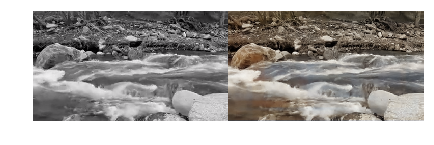

In [28]:
from data import colorize_image as CI
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color

%matplotlib inline

frame_num = 8

# Choose gpu to run the model on
gpu_id = -1

# Initialize colorization class
colorModel = CI.ColorizeImageCaffe(Xd=256)

# Load the model
colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')

# Load the image
colorModel.load_image('./bw_frames/frame{}.jpg'.format(frame_num - 1)) # load an image

mask = np.zeros((1,256,256)) # giving no user points, so mask is all 0's
input_ab = np.zeros((2,256,256)) # ab values of user points, default to 0 for no input
img_out = colorModel.net_forward(input_ab,mask) # run model, returns 256x256 image

img_gray_fullres = colorModel.get_img_gray_fullres() # get grayscale image at fullresolution
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show result
plt.figure(figsize=(7,3))
plt.imshow(np.concatenate((img_gray_fullres,img_out_fullres),axis=1)); plt.axis('off');

In [29]:
def put_point(input_ab,mask,loc,p,val):
    # input_ab    2x256x256    current user ab input (will be updated)
    # mask        1x256x256    binary mask of current user input (will be updated)
    # loc         2 tuple      (h,w) of where to put the user input
    # p           scalar       half-patch size
    # val         2 tuple      (a,b) value of user input
    input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
    mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
    return (input_ab,mask)

In [30]:
rgb = io.imread('../colorization/Result/frame{}-bw_pixmap_sat.png'.format(frame_num))
lab = color.rgb2lab(rgb)

pix_idxs    = []
pix_ab_vals = []

for row in xrange(len(lab)):
    for col in xrange(len(lab[0])):
        if list(lab[row][col]) != [0, 0, 0]:
            pix_idxs.append((row, col))
            pix_ab_vals.append(lab[row][col])
            
print pix_idxs
print pix_ab_vals

[(9, 126), (17, 158), (28, 344), (33, 171), (34, 73), (56, 22), (60, 307), (67, 240), (72, 241), (130, 111)]
[array([ 20.35251341,  -2.8499398 , -10.33523662]), array([ 48.49302328,  -2.27791497,  -9.52428009]), array([ 29.45327522,  -2.05420419,  -9.56691046]), array([ 68.38715778,  -2.61030846, -10.8211192 ]), array([ 21.81131024,  -1.84028845, -13.49102235]), array([ 35.81038687,  -1.53397445, -14.39663462]), array([ 53.69324043,  -3.17507765, -13.95274009]), array([  9.90122187,   0.41043728, -13.23231918]), array([ 24.60399813,  -1.70220817, -11.81213963]), array([ 62.84474045,  -1.9294147 , -23.86084086])]


1 ...
2 ...
3 ...
4 ...
5 ...
6 ...
7 ...
8 ...
9 ...
10 ...


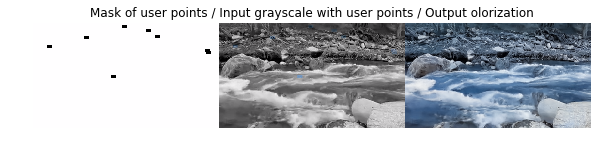

In [32]:
input_ab = np.zeros((2,256,256))
mask = np.zeros((1,256,256))
import cv2

for i in xrange(len(pix_idxs)):
    print i + 1, "..."
    # add a blue point in the middle of the image
    (input_ab,mask) = put_point(input_ab,mask,[pix_idxs[i][0],pix_idxs[i][1]],1,[pix_ab_vals[i][1],pix_ab_vals[i][2]])

    # call forward
    img_out = colorModel.net_forward(input_ab,mask)

    # get mask, input image, and result in full resolution
mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

# show user input, along with output
plt.figure(figsize=(10,6))
plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres),axis=1));
plt.title('Mask of user points / Input grayscale with user points / Output olorization')
plt.axis('off');

img_pred_withref_fullres = colorModel.get_img_fullres()
cv2.imwrite("./out_frames_features/frame{}.jpg".format(frame_num), img_pred_withref_fullres)
cv2.destroyAllWindows()
